# Data preparation 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib import pyplot as plt
%matplotlib inline
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

IMAGE_DIMS = (64,64, 3)

work_dir=os.getcwd()
print(work_dir)

saved_model=os.path.join(work_dir, 'detect_pills.model')
saved_labels=os.path.join(work_dir, 'detect_pills.labels')

trainingDatasetPath=os.path.join(work_dir, 'dataset/train')
validationDatasetPath=os.path.join(work_dir, 'dataset/validation')

imagePathsTrain = sorted(list(paths.list_images(trainingDatasetPath)))
imagePathsValidate = sorted(list(paths.list_images(validationDatasetPath)))

random.seed(42)
random.shuffle(imagePathsTrain)
random.shuffle(imagePathsValidate)

data_train = []
labels_train = []
pathes_train=[]
data_validate = []
labels_validate = []
pathes_validate=[]

def show_cv2_image(image, label):
    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)
    plt.show()
    print(label)
    

for imagePath in imagePathsTrain:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    l = imagePath.split(os.path.sep)[-2].split("_")
    labels_train.append(l)
    pathes_train.append(imagePath)
    image = img_to_array(image)
    data_train.append(image)

for imagePath in imagePathsValidate:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data_validate.append(image)
    l = imagePath.split(os.path.sep)[-2].split("_")
    labels_validate.append(l)
    pathes_validate.append(imagePath)


data_train = np.array(data_train, dtype="float") / 255.0
labels_train = np.array(labels_train)
print("[INFO] Training Images: {} images ({:.2f}MB)".format(len(imagePathsTrain), data_train.nbytes / (1024 * 1000.0)))

data_validate = np.array(data_validate, dtype="float") / 255.0
labels_validate = np.array(labels_validate)
print("[INFO] Validation images: {} images ({:.2f}MB)".format(len(imagePathsValidate), data_validate.nbytes / (1024 * 1000.0)))


mlb = MultiLabelBinarizer()
labels_train = mlb.fit_transform(labels_train)
labels_validate = mlb.fit_transform(labels_validate)

print("[INFO] encoded labels:")
print(labels_train[:5]) 

print("[INFO] classes:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))


Using TensorFlow backend.


C:\projects\2018summit
[INFO] Training Images: 157 images (15.07MB)
[INFO] Validation images: 60 images (5.76MB)
[INFO] encoded labels:
[[0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]]
[INFO] classes:
1. A
2. B
3. C
4. D
5. E
6. F


## Model Definition

In [2]:
from keras import layers
from keras import models
from keras.applications import VGG16
from keras import backend as K
from keras import regularizers


EPOCHS = 40
INIT_LR = 3e-4
BS = 40
VALIDATION_STEPS=50

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005),
                activity_regularizer=regularizers.l1(0.0005)))
model.add(layers.Dense(6, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
__________

## Training

Epoch 1/40
157/157 [==============================] - 24s 154ms/step - loss: 1.8423 - categorical_accuracy: 0.1813 - val_loss: 1.8173 - val_categorical_accuracy: 0.1667
Epoch 2/40
157/157 [==============================] - 24s 152ms/step - loss: 1.8058 - categorical_accuracy: 0.1919 - val_loss: 1.8005 - val_categorical_accuracy: 0.1667
Epoch 3/40
157/157 [==============================] - 24s 151ms/step - loss: 1.7934 - categorical_accuracy: 0.1911 - val_loss: 1.7939 - val_categorical_accuracy: 0.1667
Epoch 4/40
157/157 [==============================] - 24s 152ms/step - loss: 1.7854 - categorical_accuracy: 0.1942 - val_loss: 1.7702 - val_categorical_accuracy: 0.2000
Epoch 5/40
157/157 [==============================] - 24s 151ms/step - loss: 1.5005 - categorical_accuracy: 0.4128 - val_loss: 1.3431 - val_categorical_accuracy: 0.5000
Epoch 6/40
157/157 [==============================] - 24s 152ms/step - loss: 1.1959 - categorical_accuracy: 0.5300 - val_loss: 1.2020 - val_categorical_acc

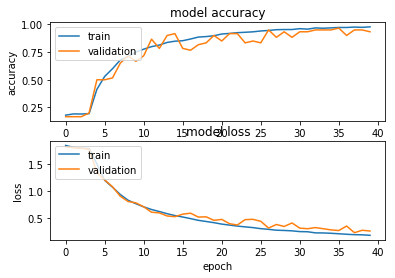

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0,height_shift_range=0, shear_range=0, 
                         zoom_range=0,horizontal_flip=True, fill_mode="nearest")

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=INIT_LR),
              metrics=['categorical_accuracy'])
history = model.fit_generator(aug.flow(data_train, labels_train, batch_size=BS),
                              validation_data=(
                                  data_validate, labels_validate),
                              steps_per_epoch=len(data_train),
                              epochs=EPOCHS,
                              validation_steps=VALIDATION_STEPS,
                              verbose=1)

model.save(saved_model)

print("[INFO] serializing label binarizer...")
f = open(saved_labels, "wb")
f.write(pickle.dumps(mlb))
f.close()

(eval_loss, eval_accuracy) = model.evaluate(data_validate, labels_validate, batch_size=len(data_train), verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

print(history.history.keys())

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## Test the model

[INFO] loading network...


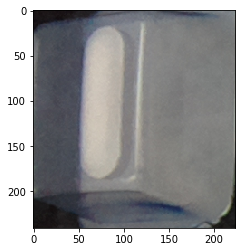

[INFO] classifying image...
C:\projects\2018summit\dataset\test\1-1-full-0cf695.png
A: 93.41%
B: 0.08%
C: 0.07%
D: 0.13%
E: 1.13%
F: 5.18%


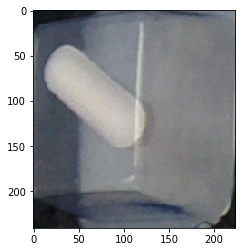

[INFO] classifying image...
C:\projects\2018summit\dataset\test\1-1-full-947ab8.png
A: 89.63%
B: 0.15%
C: 0.20%
D: 0.31%
E: 3.78%
F: 5.94%


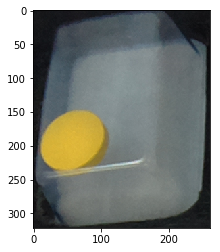

[INFO] classifying image...
C:\projects\2018summit\dataset\test\2-0-full-0668af.png
A: 0.49%
B: 98.13%
C: 0.34%
D: 0.26%
E: 0.28%
F: 0.50%


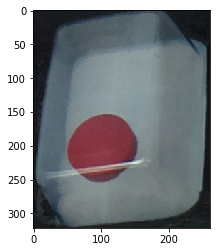

[INFO] classifying image...
C:\projects\2018summit\dataset\test\2-0-full-407e32.png
A: 0.14%
B: 0.07%
C: 0.04%
D: 99.36%
E: 0.05%
F: 0.34%


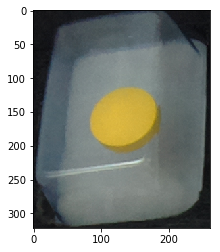

[INFO] classifying image...
C:\projects\2018summit\dataset\test\2-0-full-838083.png
A: 0.28%
B: 98.96%
C: 0.18%
D: 0.15%
E: 0.15%
F: 0.28%


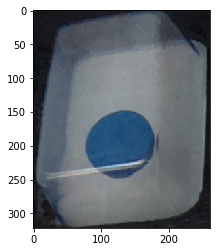

[INFO] classifying image...
C:\projects\2018summit\dataset\test\2-0-full-9dedc6.png
A: 0.01%
B: 0.00%
C: 99.85%
D: 0.00%
E: 0.12%
F: 0.01%


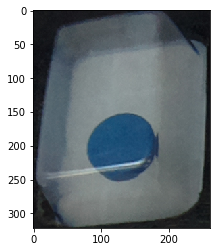

[INFO] classifying image...
C:\projects\2018summit\dataset\test\2-0-full-f53358.png
A: 0.01%
B: 0.01%
C: 99.71%
D: 0.01%
E: 0.23%
F: 0.03%


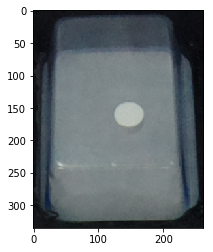

[INFO] classifying image...
C:\projects\2018summit\dataset\test\3-0-full-79a37e.png
A: 1.18%
B: 0.02%
C: 0.55%
D: 0.04%
E: 97.20%
F: 1.01%


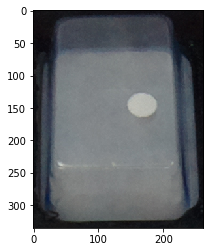

[INFO] classifying image...
C:\projects\2018summit\dataset\test\3-0-full-a3d0f0.png
A: 1.69%
B: 0.03%
C: 0.74%
D: 0.06%
E: 95.95%
F: 1.53%


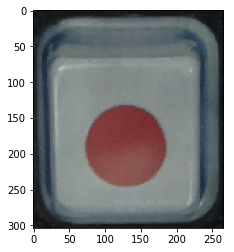

[INFO] classifying image...
C:\projects\2018summit\dataset\test\3-2-full-4d56ca.png
A: 0.09%
B: 0.04%
C: 0.02%
D: 99.61%
E: 0.03%
F: 0.22%


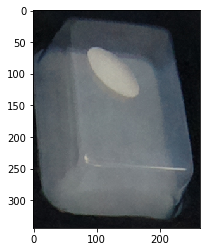

[INFO] classifying image...
C:\projects\2018summit\dataset\test\4-0-full-e7c745.png
A: 7.98%
B: 0.46%
C: 0.11%
D: 0.38%
E: 1.10%
F: 89.97%


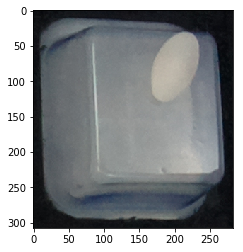

[INFO] classifying image...
C:\projects\2018summit\dataset\test\4-1-full-ca165d.png
A: 2.41%
B: 0.37%
C: 0.11%
D: 0.94%
E: 1.19%
F: 94.98%


In [4]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline
from imutils import paths

saved_model=os.path.join(work_dir, 'detect_pills.model')
saved_labels=os.path.join(work_dir, 'detect_pills.labels')
testDatasetPath=os.path.join(work_dir, 'dataset\\test')

imagePaths = sorted(list(paths.list_images(testDatasetPath)))

print("[INFO] loading network...")
model = load_model(saved_model)
mlb = pickle.loads(open(saved_labels, "rb").read())

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)
    plt.show()
    output = imutils.resize(image, width=300)

    # pre-process the image for classification
    image = cv2.resize(image, (64, 64))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    print("[INFO] classifying image...")
    proba = model.predict(image)[0]
    
    print (imagePath)
    # show the probabilities for each of the individual labels
    for (label, p) in zip(mlb.classes_, proba):
        print("{}: {:.2f}%".format(label, p * 100))
    
